In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import numpy as np
import random
import sys

sys.path.append('../tools')

import os

import torch

import pandas as pd
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks
import data_utility, annotation_utility
from models.rns_dataloader import *
from active_learning_utility import get_strategy
from active_learning_data import Data
from active_learning_net import Net
from copy import deepcopy
from models.SwaV import SwaV
from models.LSTMDownStream import SupervisedDownstream
import warnings
import pickle
warnings.filterwarnings("ignore")


In [3]:
random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)
    # True ensures the algorithm selected by CUFA is deterministic
    torch.backends.cudnn.deterministic = True
    # torch.set_deterministic(True)
    # False ensures CUDA select the same algorithm each time the application is run
    torch.backends.cudnn.benchmark = False

import pytorch_lightning

pytorch_lightning.utilities.seed.seed_everything(seed=random_seed, workers=True)

Global seed set to 42


42

In [4]:
data_dir = "../../../user_data/"
log_folder_root = '../../../user_data/logs/'
ckpt_folder_root = '../../../user_data/checkpoints/'

In [5]:
strategy_name = 'EntropySampling'

In [6]:
nStart = 1
nEnd = 20
nQuery = 2

In [7]:
args_task = {'n_epoch': 50,
             'transform_train': True,
             'strategy_name': strategy_name,
             'transform': False,
             'loader_tr_args': {'batch_size': 2, 'num_workers': 4, 'collate_fn': collate_fn,
                                'drop_last': True, 'persistent_workers': True},
             'loader_te_args': {'batch_size': 2, 'num_workers': 4, 'collate_fn': collate_fn,
                                'drop_last': True, 'persistent_workers': True}
             }

In [8]:
# raw_annotations = pd.read_csv(data_dir + 'full_updated_anns_annotTbl_cleaned.csv')
# ids = list(np.unique(raw_annotations[raw_annotations['descriptions'].notnull()]['HUP_ID']))
# # ids = list(np.unique(raw_annotations['HUP_ID']))
#
# data_import = data_utility.read_files(path=data_dir+'rns_data', path_data=data_dir+'rns_raw_cache', patientIDs=ids,
#                                       verbose=True)  # Import data with annotation

In [9]:
# data_list = os.listdir(data_dir+'rns_test_cache')
# print(data_list)
data_list = ['HUP047.npy', 'HUP084.npy', 'HUP096.npy', 'HUP109.npy', 'HUP121.npy', 'HUP129.npy', 'HUP131.npy',
             'HUP137.npy', 'HUP147.npy', 'HUP156.npy', 'HUP159.npy', 'HUP182.npy', 'HUP197.npy', 'HUP199.npy',
             'RNS026.npy', 'RNS029.npy']
# data_list = os.listdir(data_dir+'rns_test_cache')[1:]

# data_list = ['HUP182.npy',   'HUP129.npy',   'HUP109.npy', 'HUP156.npy', 'HUP096.npy', 'RNS026.npy',  'HUP159.npy']
# data_list = ['RNS026.npy', 'HUP159.npy', 'HUP129.npy', 'HUP096.npy', 'HUP182.npy']
train_data, train_label, test_data, test_label, train_index, test_index = get_data_by_episode(data_list, split=0.8)
# data, label,_,_ = get_data(data_list, split=1)
# train_data, test_data, train_label, test_label = sklearn.model_selection.train_test_split(data, label, test_size=0.8, random_state=42)

print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

16it [00:06,  2.39it/s]

(992,)
(992,)
(270,)
(270,)


In [10]:
X_train = np.concatenate(train_data)
y_train = np.concatenate(train_label)
X_test = np.concatenate(test_data)
y_test = np.concatenate(test_label)
index_train = np.concatenate(train_index)
index_test = np.concatenate(test_index)
seq_len_train = np.array([y.shape[0] for y in train_label])
seq_len_test = np.array([y.shape[0] for y in test_label])

In [11]:
n_pool = len(train_data)
n_test = len(test_data)

NUM_INIT_LB = int(nStart * n_pool / 100)
NUM_QUERY = int(nQuery * n_pool / 100) if nStart != 100 else 0
NUM_ROUND = int((int(nEnd * n_pool / 100) - NUM_INIT_LB) / NUM_QUERY) if nStart != 100 else 0
if NUM_QUERY != 0:
    if (int(nEnd * n_pool / 100) - NUM_INIT_LB) % NUM_QUERY != 0:
        NUM_ROUND += 1

print(NUM_INIT_LB)
print(NUM_QUERY)
print(NUM_ROUND)

9
19
10


In [12]:
dataset = Data(X_train, y_train, X_test, y_test, seq_len_train, seq_len_test, RNS_Active_by_episode_LSTM, args_task)

In [13]:
swav = SwaV().load_from_checkpoint(
    ckpt_folder_root + 'rns_swav_50_12/rns_swav-epoch=82-swav_loss=2.58204.ckpt')
model = SupervisedDownstream(swav.backbone)
# initialize model and save the model state
modelstate = deepcopy(model.state_dict())
device = "cuda" if torch.cuda.is_available() else "cpu"

net = Net(model, args_task, device, ckpt_folder_root='rns_active', log_folder_root='rns_active')

In [14]:
strategy = get_strategy(strategy_name, dataset, net, None, args_task, rns_data=True)

In [15]:
# initial round of training, round 0
dataset.initialize_labels(NUM_INIT_LB)

In [16]:
ids,_ = dataset.get_labeled_data()

selected_inds = {}
selected_inds[0] = ids

if not os.path.exists(log_folder_root + 'rns_active_selected/' + strategy_name):
    os.makedirs(log_folder_root + 'rns_active_selected/' + strategy_name)

# Serialize and save to a file
with open(log_folder_root + 'rns_active_selected/' + strategy_name + '/' + 'selected_indices.pkl', 'wb') as f:
    pickle.dump(selected_inds, f)

In [17]:
strategy.train()

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [67]:


probs, seq_len = strategy.predict_prob(unlabeled_data)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


85111
85111
85111
85111


Predicting: 4it [00:00, ?it/s]

In [192]:
unlabeled_idxs, unlabeled_data = strategy.dataset.get_train_data_unaugmented()

85111
85111
85111
85111


In [194]:
np.concatenate(unlabeled_data.label)

array([0., 0., 0., ..., 0., 0., 0.])

In [280]:
n = 1700
log_probs = torch.log(probs)
uncertainties = (probs * log_probs).sum(1)
indices = np.argsort(uncertainties)
data_sorted = uncertainties[indices]
original_order = indices.argsort()
data_original = data_sorted[original_order]
cdf = np.arange(1, len(uncertainties) + 1) / len(uncertainties)
linear_data = np.interp(cdf, (cdf.min(), cdf.max()), (0, 1))






In [217]:
probs.argmax(1)

tensor([0, 0, 0,  ..., 0, 0, 0])

In [130]:
uncertainties.sort()[1][:n]

tensor([82222, 37209,  7932,  ..., 62857, 50579, 35576])

In [1]:
metrics = strategy.dataset.combine_window_to_episode(-0.1-uncertainties, seq_len)
to_select = strategy.get_combined_important(torch.flatten(seq_len), metrics, 1700)
print('selected', np.sum(to_select))

NameError: name 'strategy' is not defined

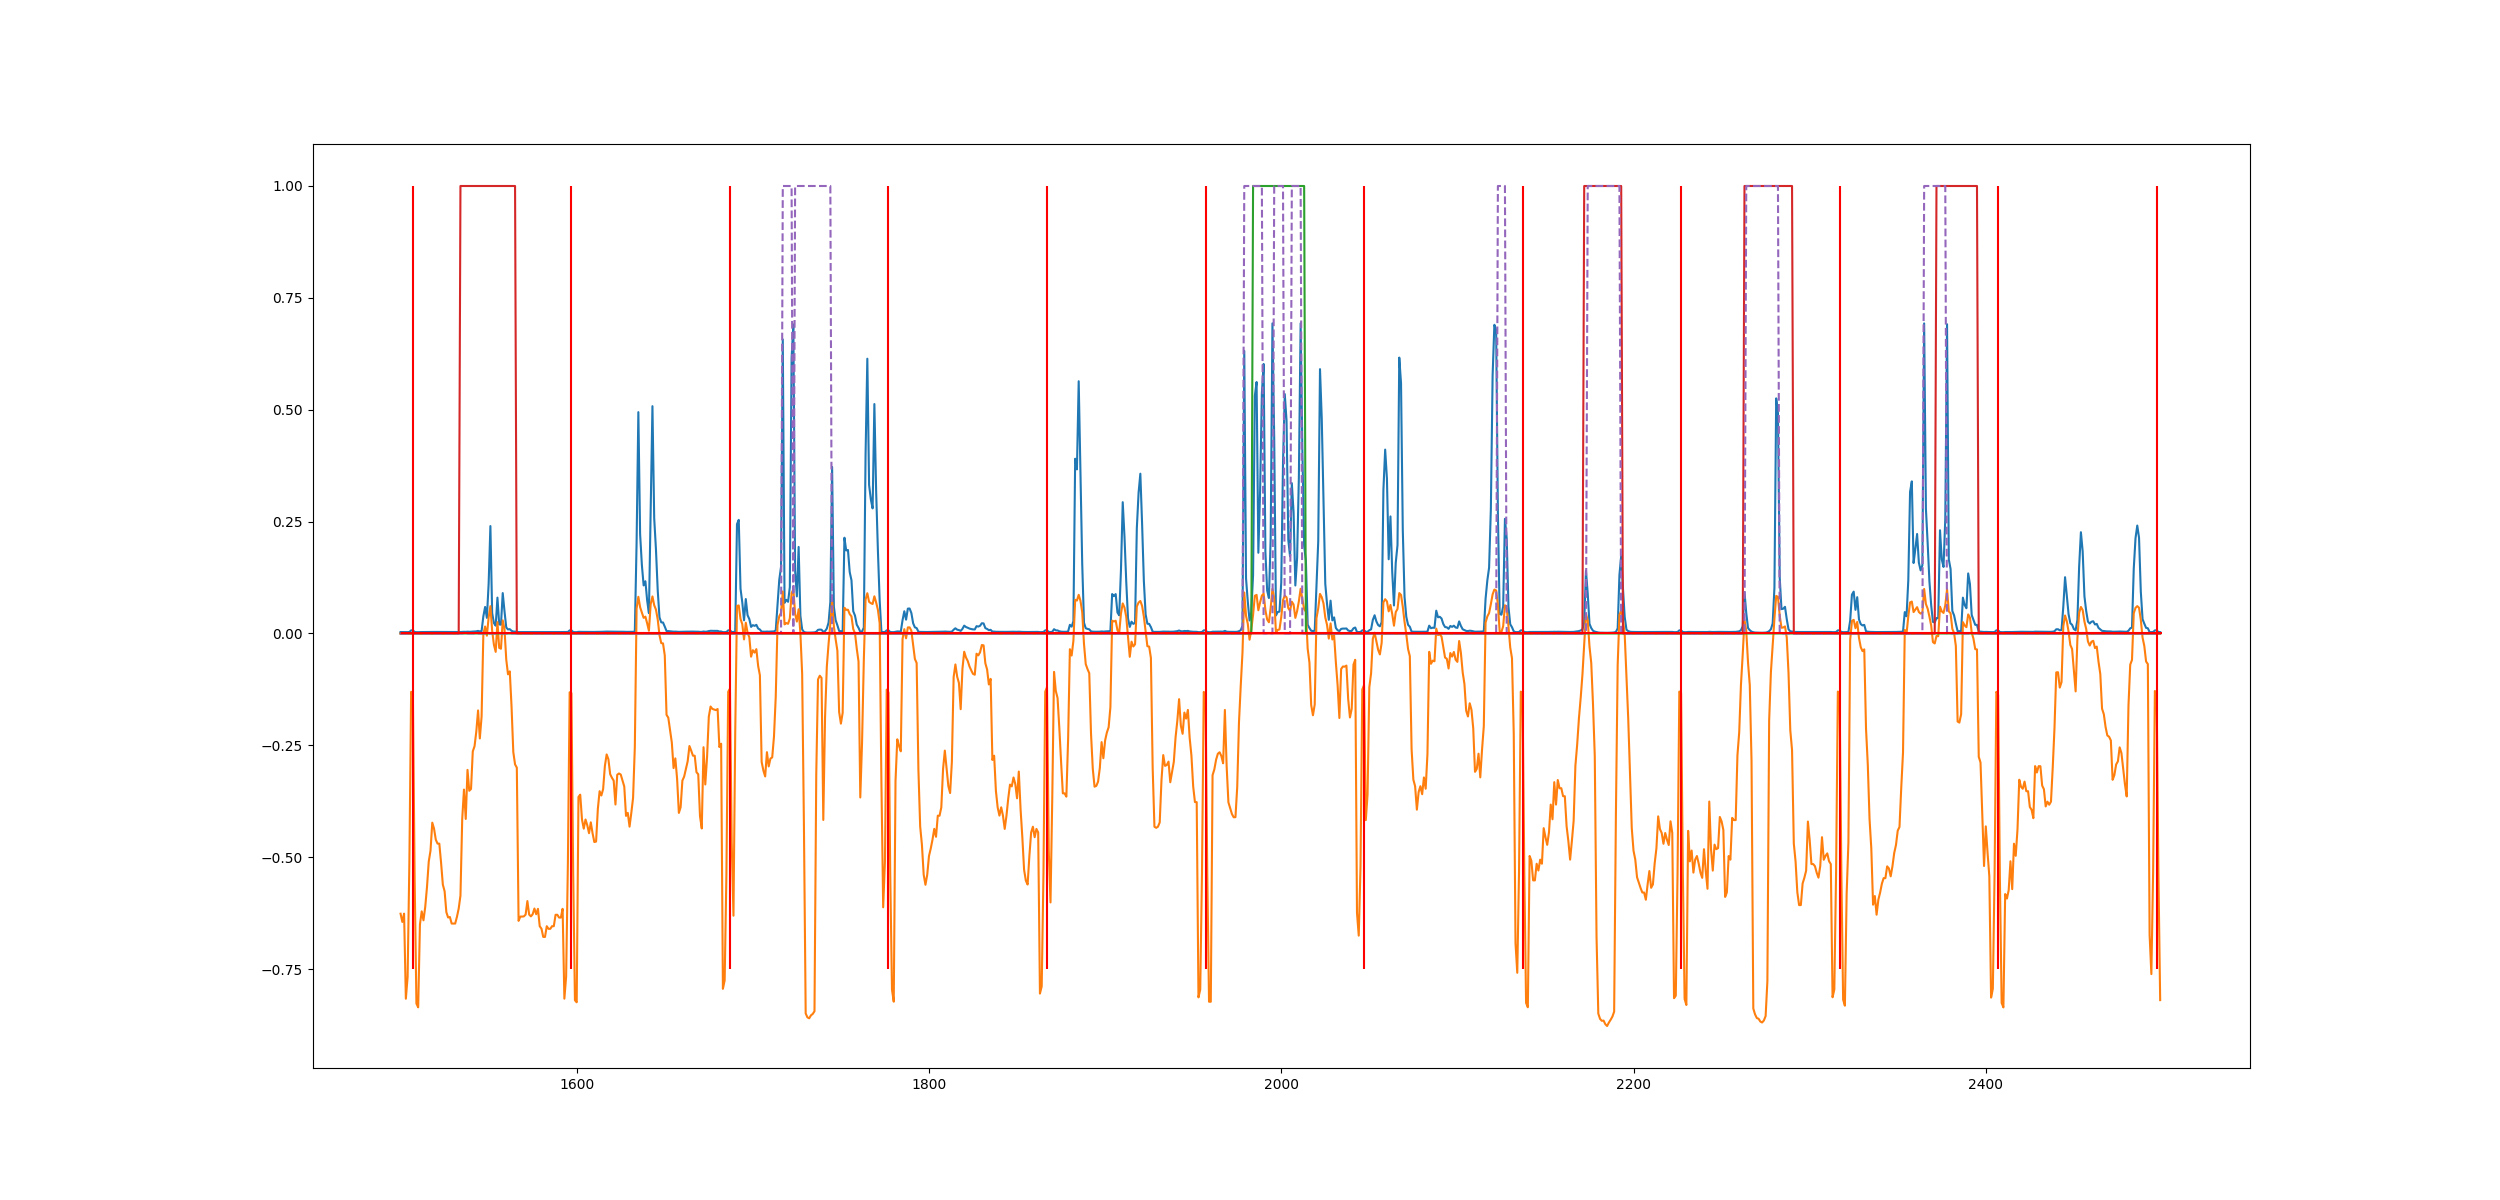

In [283]:
to_plot1 = 1500
to_plot2 = 2500
import matplotlib.pyplot as plt
x = np.arange(to_plot1,to_plot2)
plt.figure(figsize=(25,12))
plt.plot(x,-uncertainties[to_plot1:to_plot2])
plt.plot(x,0.1-linear_data[original_order][to_plot1:to_plot2])
plt.plot(x,to_select[to_plot1:to_plot2])
plt.plot(x,np.concatenate(unlabeled_data.label)[to_plot1:to_plot2])
plt.plot(x,probs.argmax(1)[to_plot1:to_plot2], '--')
plt.hlines(0,to_plot1,to_plot2,colors='red')
plt.vlines(np.cumsum(seq_len)[np.where((np.cumsum(seq_len)>to_plot1)&(np.cumsum(seq_len)<to_plot2))[0]],-0.75,1, colors='red')
plt.show()

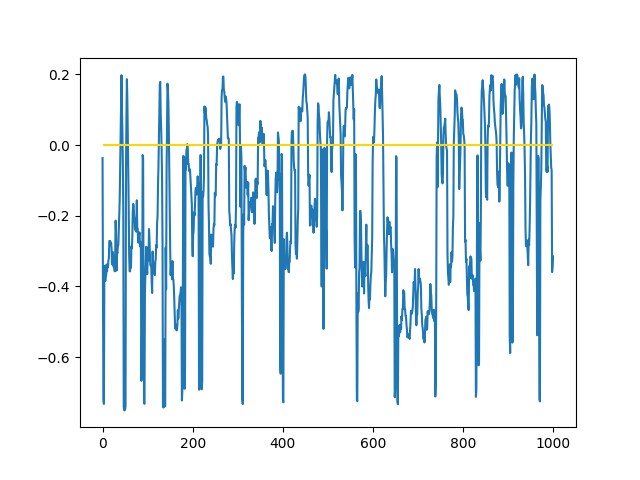

In [149]:
plt.figure()
plt.plot(0.2-linear_data[original_order][:to_plot])
plt.hlines(0,0,to_plot,colors='gold')
plt.show()

tensor([ 90, 180, 218, 308, 398, 488, 562, 652, 742, 832, 907, 967])

In [117]:
len(uncertainties)

85111

In [105]:

linear_data2, seq_len2 = strategy.dataset.get_slice_from_episode(linear_data[data_sorted_argsort], seq_len, ~unlabeled_idxs)
linear_data3 = np.concatenate(linear_data2)

85111
tensor(85111)
84332
tensor(85111)


AssertionError: 

In [107]:
threshold = 0.90

linear_data4 = strategy.dataset.combine_window_to_episode(threshold - linear_data3, seq_len2)
to_select = strategy.get_combined_important(torch.flatten(seq_len2), linear_data4, n)

unlabeled_idxs, _ = strategy.dataset.get_unlabeled_data()
print('selected', np.sum(to_select), threshold)

84332
tensor(84332)
total_select_from 82791.0
85111
85111
85111
85111
selected 1777.0 0.9


In [109]:
np.argsort(threshold - linear_data3)

array([19576, 53686, 76852, ..., 77462, 53450, 19792], dtype=int64)

85111
tensor(85111)
85111
tensor(85111)


In [56]:
uncertainties = probs.max(1)[0]
uncertainties, seq_len = strategy.dataset.get_slice_from_episode(uncertainties, seq_len, ~unlabeled_idxs)

85111
tensor(84332)


AssertionError: 

In [52]:
log_probs = torch.log(probs)
uncertainties = (probs * log_probs).sum(1)

In [53]:
len(uncertainties)

85111

In [55]:
cum_sum_index = np.cumsum(seq_len)
cum_sum_index = np.insert(cum_sum_index, 0, 0)


print(len(uncertainties))
print(cum_sum_index[-1])

85111
tensor(84332)


In [36]:
uncertainties.sort()[0][:100]

tensor([-0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6931,
        -0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6931,
        -0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6931,
        -0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6930, -0.6930,
        -0.6930, -0.6930, -0.6930, -0.6930, -0.6930, -0.6930, -0.6930, -0.6930,
        -0.6930, -0.6929, -0.6929, -0.6929, -0.6929, -0.6929, -0.6929, -0.6929,
        -0.6929, -0.6929, -0.6929, -0.6928, -0.6928, -0.6928, -0.6928, -0.6928,
        -0.6927, -0.6927, -0.6927, -0.6927, -0.6927, -0.6927, -0.6927, -0.6927,
        -0.6927, -0.6927, -0.6927, -0.6927, -0.6926, -0.6926, -0.6926, -0.6926,
        -0.6926, -0.6926, -0.6925, -0.6925, -0.6924, -0.6924, -0.6924, -0.6924,
        -0.6923, -0.6923, -0.6923, -0.6923, -0.6922, -0.6922, -0.6922, -0.6922,
        -0.6922, -0.6922, -0.6922, -0.6921, -0.6921, -0.6920, -0.6919, -0.6919,
        -0.6919, -0.6918, -0.6918, -0.69

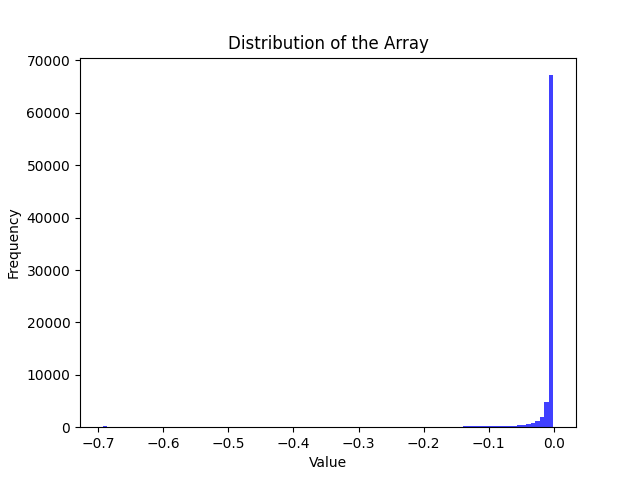

In [22]:
import matplotlib.pyplot as plt
plt.figure()
plt.hist(uncertainties, bins=100, alpha=0.75, color='blue')
plt.title('Distribution of the Array')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

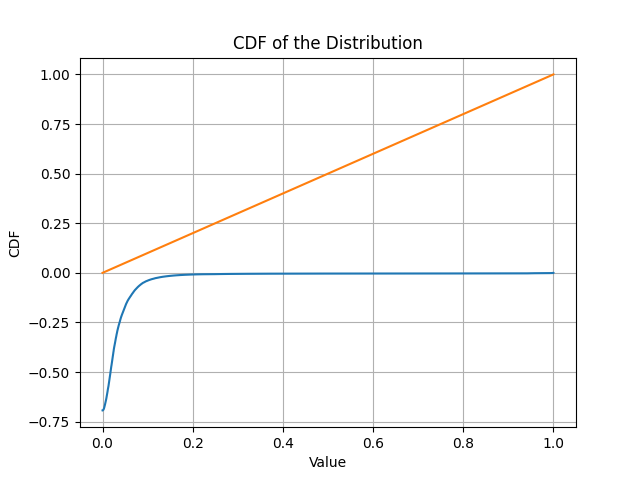

In [140]:


# Plotting the CDF
plt.figure()
plt.plot(cdf, data_sorted)
plt.plot(linear_data,cdf)
plt.title('CDF of the Distribution')
plt.xlabel('Value')
plt.ylabel('CDF')
plt.grid(True)
plt.show()

In [38]:
np.vstack((data_sorted,cdf,linear_data))

array([[-6.93147182e-01, -6.93147063e-01, -6.93146408e-01, ...,
        -7.24521873e-04, -7.06738792e-04, -6.49171066e-04],
       [ 1.17493626e-05,  2.34987252e-05,  3.52480878e-05, ...,
         9.99976501e-01,  9.99988251e-01,  1.00000000e+00],
       [ 1.00000000e+00,  9.99988250e-01,  9.99976501e-01, ...,
         2.34990013e-05,  1.17495006e-05,  0.00000000e+00]])

In [50]:
n= 1700
linear_data, seq_len = strategy.dataset.get_slice_from_episode(uncertainties, seq_len, ~unlabeled_idxs)
# linear_data = np.concatenate(linear_data)
#
# threshold = 0.97
#
# metrics = strategy.dataset.combine_window_to_episode(threshold - uncertainties, seq_len)
# to_select = strategy.get_combined_important(torch.flatten(seq_len), metrics, n)
#
# unlabeled_idxs, _ = strategy.dataset.get_unlabeled_data()
# print('selected', np.sum(to_select), threshold)

85111
tensor(84332)


AssertionError: 

In [58]:
len(linear_data)

84332

In [42]:
np.cumsum(seq_len)

tensor([   90,   180,   218,   308,   398,   488,   562,   652,   742,   832,
          907,   967,  1057,  1147,  1237,  1327,  1417,  1507,  1597,  1687,
         1777,  1867,  1957,  2047,  2137,  2227,  2317,  2407,  2497,  2587,
         2677,  2767,  2857,  2947,  3037,  3127,  3217,  3307,  3397,  3487,
         3577,  3667,  3757,  3814,  3904,  3994,  4084,  4174,  4264,  4354,
         4444,  4534,  4624,  4714,  4804,  4894,  4984,  5074,  5164,  5254,
         5344,  5434,  5524,  5614,  5704,  5794,  5884,  5974,  6064,  6154,
         6244,  6334,  6424,  6514,  6604,  6694,  6784,  6874,  6964,  7054,
         7144,  7234,  7324,  7414,  7504,  7594,  7624,  7714,  7804,  7894,
         7984,  8074,  8164,  8254,  8344,  8434,  8524,  8614,  8687,  8777,
         8867,  8957,  9047,  9137,  9227,  9317,  9407,  9497,  9587,  9677,
         9767,  9857,  9947, 10037, 10127, 10217, 10307, 10397, 10487, 10577,
        10667, 10757, 10847, 10937, 11027, 11116, 11206, 11296, 

Text(0.5, 1.0, 'Linear Transformation with Slope of 1')

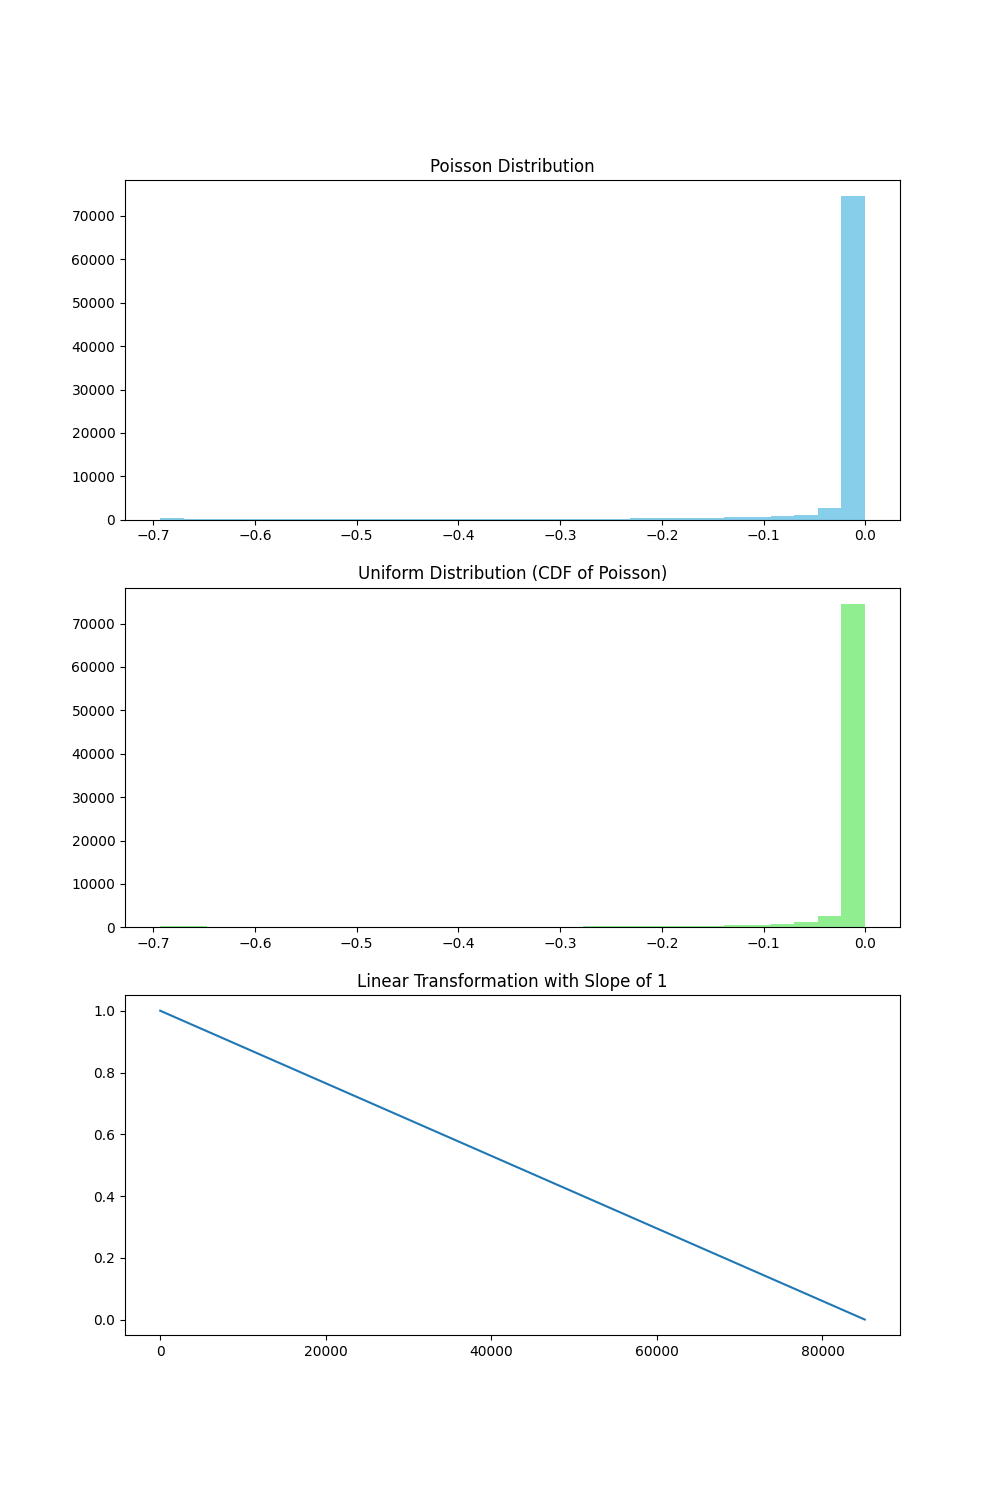

In [37]:


fig, axs = plt.subplots(3, 1, figsize=(10, 15))

axs[0].hist(uncertainties, bins=30, color='skyblue')
axs[0].set_title("Poisson Distribution")

axs[1].hist(uncertainties, bins=30, color='lightgreen')
axs[1].set_title("Uniform Distribution (CDF of Poisson)")

axs[2].plot(linear_data)
axs[2].set_title("Linear Transformation with Slope of 1")

In [ ]:

for rd in range(1, NUM_ROUND + 1):
    print('round ' + str(rd))
    log_file_name = log_folder_root + 'rns_active/active_logs_' + strategy_name + '/logger_round_' + str(
        rd - 1) + '/version_0/metrics.csv'
    logs = pd.read_csv(log_file_name)
    max_ind = logs['val_acc'].argmax()
    max_row = logs.iloc[max_ind]
    ckpt_directory = ckpt_folder_root + 'rns_active/active_checkpoints_' + strategy_name
    ckpt_files = os.listdir(ckpt_directory)
    load_file_name = strategy_name + '_round_' + str(rd - 1) + '-epoch=' + str(int(max_row['epoch'])).zfill(2)

    ind = next((i for i, s in enumerate(ckpt_files) if load_file_name in s), None)
    print(ind, ckpt_files[ind])
    strategy.net.net.load_from_checkpoint(ckpt_directory + '/' + ckpt_files[ind], backbone=swav.backbone)

    q_idxs = strategy.query(NUM_QUERY * 90)

    with open(log_folder_root + 'rns_active_selected/' + strategy_name + '/' + 'selected_indices.pkl', 'rb') as f:
    # Load the content of the file into a Python object
        selected_inds = pickle.load(f)
    selected_inds[rd] = q_idxs
    with open(log_folder_root + 'rns_active_selected/' + strategy_name + '/' + 'selected_indices.pkl', 'wb') as f:
        pickle.dump(selected_inds, f)
# Now you can use the dictionary object as usual
    strategy.update(q_idxs)
    strategy.net.round = rd
    strategy.net.net.load_state_dict(modelstate)
    strategy.train()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


round 1
1


Predicting: 4it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4it [00:00, ?it/s]

total_select_from 83349.0
selected 1780.0 0.97


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]